#  Human mobility and COVID-19 epidemic (Rt calculation)

Student: Nguyen Xuan Tung

ID: 2005491


## Library

In [1]:
import string         #(module for string)
import sys            #(module system)
import numpy as np    #(module mathematical stuff)
import pandas as pd 
import seaborn as sns
import random 
import fileinput
import math
import operator
import scipy
import csv
import itertools
from covid19dh import covid19
import statistics

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors

from scipy.stats import poisson
from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

pd.options.mode.chained_assignment = None  # default='warn'

-------------------------------------------------------------------------------------------------------------

## $R_t$ data

reference link: https://www.medrxiv.org/content/10.1101/2020.05.06.20093039v3.full

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

#### Estimating COVID-19's $R_t$ in Real-Time

In any epidemic, $R_t$ is the measure known as the effective reproduction number. It's the number of people who become infected per infectious person at time $t$. The most well-known version of this number is the basic reproduction number: $R_0$ when $t=0$. However, $R_0$ is a single measure that does not adapt with changes in behavior and restrictions.

As a pandemic evolves, increasing restrictions (or potential releasing of restrictions) change $R_t$. Knowing the current $R_t$ is essential. When $R>1$, the pandemic will spread through the entire population. If $R_t<1$, the pandemic will grow to some fixed number less than the population. The lower $R_t$, the more manageable the situation. The value of $R_t$ helps us (1) understand how effective our measures have been controlling an outbreak and (2) gives us vital information about whether we should increase or reduce restrictions based on our competing goals of economic prosperity and human safety. [Well-respected epidemiologists argue](https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html) that tracking $R_t$ is the only way to manage through this crisis.

Yet, today, to my knowledge there is no real-time tracking of $R_t$ in United States. In fact, the only real-time measure I've seen has been for [Hong Kong](https://covid19.sph.hku.hk/dashboard). More importantly, it is not useful to understand $R_t$ at a national level. Instead, to manage this crisis effectively, we need a local (state, county and/or city) level granularity of $R_t$.

What follows is a solution to this problem at the US State level. It's a modified version of a solution created by [Bettencourt & Ribeiro 2008](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) to estimate real-time $R_t$ using a Bayesian approach. While I have stayed true to most of their process, my solution differs in an important way that I will call out clearly.

If you have questions, comments, or improvments feel free to get in touch: [hello@systrom.com](mailto:hello@systrom.com). And if it's not entirely clear, I'm not an epidemiologist. At the same time, data is data, and statistics are statistics and this is based on work by well-known epidemiologists so calibrate accordingly. In the meantime, I hope you can learn something new as I did by reading through this example. Feel free to take this work and apply it elsewhere – internationally or to counties in the United States.


#### Bettencourt & Ribeiro's Approach

Every day, we learn how many more people have COVID-19. This new case count gives us a clue about the current value of $R_t$. We also, figure that the value of $R_t$ today is related to the value of $R_{t-1}$ (yesterday's value) and every previous value of $R_{t-m}$ for that matter.

With these insights, the authors use [Bayes' rule](https://en.wikipedia.org/wiki/Bayes%27_theorem) to update their beliefs about the true value of $R_t$ based on how many new cases have been reported each day.

This is Bayes' Theorem as we'll use it:

$$ P(R_t|k)=\frac{P(R_t)\cdot\mathcal{L}(R_t|k)}{P(k)} $$

This says that, having seen $k$ new cases, we believe the distribution of $R_t$ is equal to:

- The __prior__ beliefs of the value of $P(R_t)$ without the data ...
- times the __likelihood__ of $R_t$ given that we've seen $k$ new cases ...
- divided by the probability of seeing this many cases in general.

Importantly, $P(k)$ is a constant, so the numerator is proportional to the posterior. Since all probability distributions sum to 1.0, we can ignore $P(k)$ and normalize our posterior to sum to 1.0:

$$ P(R_t|k) \propto P(R_t) \cdot \mathcal{L}(R_t|k) $$

This is for a single day. To make it iterative: every day that passes, we use yesterday's conclusion (ie. posterior) $P(R_{t-1}|k_{t-1})$ to be today's prior $P(R_t)$ so on day two:

$$ P(R_2|k) \propto P(R_0)\cdot\mathcal{L}(R_2|k_2)\cdot\mathcal{L}(R_1|k_1) $$

And more generally:

$$ P(R_t|k_t) \propto P(R_0) \cdot {\displaystyle \prod^{T}_{t=0}}\mathcal{L}(R_t|k_t) $$

With a uniform prior $P(R_0)$, this reduces to:

$$ P(R_t|k_t) \propto {\displaystyle \prod^{T}_{t=0}}\mathcal{L}\left(R_t|k_t\right) $$

#### Proposed Modification

This works fine, but it suffers from an issue: the posterior on any given day is equally influenced by the distant past as much as the recent day. For epidemics that have $R_t>1$ for a long time and then become under control ($R_t<1$), the posterior gets stuck. It cannot forget about the many days where $R_t>1$ so eventually $P(R_t|k)$ asymptotically approaches 1 when we know it's well under 1. The authors note this in the paper as a footnote. Unfortunately this won't work for us. __The most critical thing to know is when we've dipped below the 1.0 threshold!__

So, I propose to only incorporate the last $m$ days of the likelihood function. By doing this, the algorithm's prior is built based on the recent past which is a much more useful prior than the entire history of the epidemic. So this simple, but important change leads to the following:

$$ P(R_t|k_t) \propto {\displaystyle \prod^{T}_{t=T-m}}\mathcal{L}\left(R_t|k_t\right) $$

While this takes the last $m$ priors into account equally, you can decide to apply a windowing function (such as an exponential) to favor recent priors over more distant.

#### Choosing a Likelihood Function $\mathcal{L}\left(R_t|k_t\right)$

A likelihood function function says how likely a value of $R_t$ is given an observed number of new cases $k$.

Any time you need to model 'arrivals' over some time period of time, statisticians like to use the [Poisson Distribution](https://en.wikipedia.org/wiki/Poisson_distribution). Given an average arrival rate of $\lambda$ new cases per day, the probability of seeing $k$ new cases is distributed according to the Poisson distribution:

$$P(k|\lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$$

In [3]:
# Column vector of k
k = np.arange(0, 70)[:, None]

# Different values of Lambda
lambdas = [10, 20, 30, 40]

# Evaluated the Probability Mass Function (remember: poisson is discrete)
y = sps.poisson.pmf(k, lambdas)

# Show the resulting shape
print(y.shape)

(70, 4)


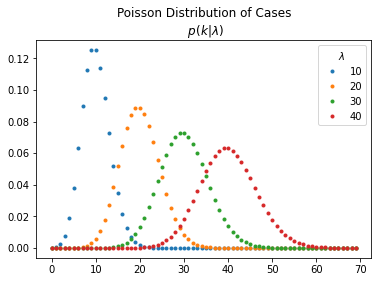

In [4]:
fig, ax = plt.subplots()

ax.set(title='Poisson Distribution of Cases\n $p(k|\lambda)$')

plt.plot(k, y,
         marker='o',
         markersize=3,
         lw=0)

plt.legend(title="$\lambda$", labels=lambdas);

The Poisson distribution says that if you think you're going to have $\lambda$ cases per day, you'll probably get that many, plus or minus some variation based on chance.

But in our case, we know there have been $k$ cases and we need to know what value of $\lambda$ is most likely. In order to do this, we fix $k$ in place while varying $\lambda$. __This is called the likelihood function.__

For example, imagine we observe $k=20$ new cases, and we want to know how likely each $\lambda$ is:

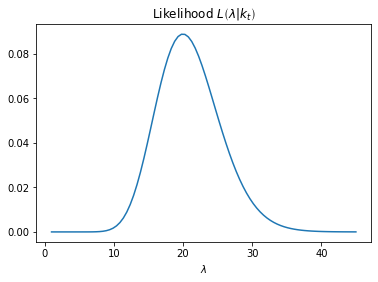

In [5]:
k = 20

lam = np.linspace(1, 45, 90)

likelihood = pd.Series(data=sps.poisson.pmf(k, lam),
                       index=pd.Index(lam, name='$\lambda$'),
                       name='lambda')

likelihood.plot(title=r'Likelihood $L\left(\lambda|k_t\right)$');

This says that if we see 20 cases, the most likely value of $\lambda$ is (not surprisingly) 20. But we're not certain: it's possible lambda was 21 or 17 and saw 20 new cases by chance alone. It also says that it's unlikely $\lambda$ was 40 and we saw 20.

Great. We have $\mathcal{L}\left(\lambda_t|k_t\right)$ which is parameterized by $\lambda$ but we were looking for $\mathcal{L}\left(R_t|k_t\right)$ which is parameterized by $R_t$. We need to know the relationship between $\lambda$ and $R_t$

#### Connecting $\lambda$ and $R_t$

__The key insight to making this work is to realize there's a connection between $R_t$ and $\lambda$__. [The derivation](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) is beyond the scope of this notebook, but here it is:

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

where $\gamma$ is the reciprocal of the serial interval ([about 4 days for COVID19](https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article)). Since we know every new case count on the previous day, we can now reformulate the likelihood function as a Poisson parameterized by fixing $k$ and varying $R_t$.

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

$$\mathcal{L}\left(R_t|k\right) = \frac{\lambda^k e^{-\lambda}}{k!}$$

#### Evaluating the Likelihood Function

To contiue our example, let's imagine a sample of new case counts $k$. What is the likelihood of different values of $R_t$ on each of those days?

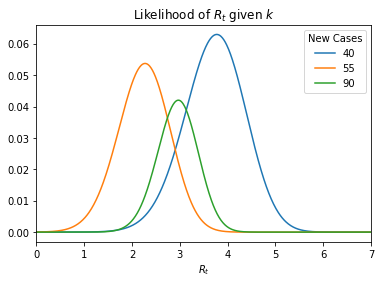

In [6]:
k = np.array([20, 40, 55, 90])

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article
GAMMA = 1/4

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t / np.sum(likelihood_r_t, axis=0)

# Plot it
ax = pd.DataFrame(
    data = likelihood_r_t,
    index = r_t_range
).plot(
    title='Likelihood of $R_t$ given $k$',
    xlim=(0,7)
)

ax.legend(labels=k[1:], title='New Cases')
ax.set_xlabel('$R_t$');

You can see that each day we have a independent guesses for $R_t$. The goal is to combine the information we have about previous days with the current day. To do this, we use Bayes' theorem.

#### Performing the Bayesian Update

To perform the Bayesian update, we need to multiply the likelihood by the prior (which is just the previous day's likelihood) to get the posteriors. Let's do that using the cumulative product of each successive day:

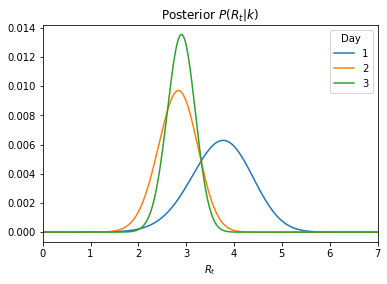

In [7]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

ax = posteriors.plot(
    title='Posterior $P(R_t|k)$',
    xlim=(0,7)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$');

Notice how on Day 1, our posterior matches Day 1's likelihood from above? That's because we have no information other than that day. However, when we update the prior using Day 2's information, you can see the curve has moved left, but not nearly as left as the likelihood for Day 2 from above. This is because Bayesian updating uses information from both days and effectively averages the two. Since Day 3's likelihood is in between the other two, you see a small shift to the right, but more importantly: a narrower distribution. We're becoming __more__ confident in our believes of the true value of $R_t$.

From these posteriors, we can answer important questions such as "What is the most likely value of $R_t$ each day?"

In [8]:
most_likely_values = posteriors.idxmax(axis=0)
most_likely_values

Day
1    3.77
2    2.84
3    2.90
dtype: float64

We can also obtain the [highest density intervals](https://www.sciencedirect.com/topics/mathematics/highest-density-interval) for $R_t$:

> Note: I apologize in advance for the clunky brute force HDI algorithm. Please let me know if there are better ones out there.

In [9]:
def highest_density_interval(pmf, p=.9):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf], index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
    #new condition:
    #if no values has been found so far, and cumsum[0] is already above 1-p
    #the first term of the tuple is the index cumsum[0], i.e. 0
    #the second term of the tuple is the very first that reaches 1.0 in the cumulative term
 
    if (best == None) and ((1. - p) < cumsum[0]):
        for j, high_value in enumerate(cumsum[1:]):
            if high_value == 1.:
                best = (0, j+1)
                break
    #sometimes R_t estimate can be bugged and CI overestimated, therefore take the pair of values that
    #have the same values
    if (best == None) and (cumsum[-1] < 1):
        for j, high_value in enumerate(cumsum[1:]):
            if (cumsum[j+2]-cumsum[j+1] == 0.):
                best = (0, j+1)
                break
                
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    return pd.Series([low, high], index=[f'Low_{p*100:.0f}', f'High_{p*100:.0f}'])

hdi = highest_density_interval(posteriors)
hdi.tail()

,Low_90,High_90
Day,,
1,2.69,4.78
2,2.17,3.53
3,2.41,3.38


Finally, we can plot both the most likely values for $R_t$ and the HDIs over time. This is the most useful representation as it shows how our beliefs change with every day.

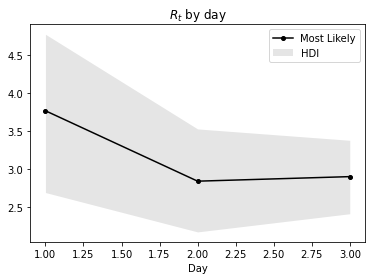

In [10]:
ax = most_likely_values.plot(marker='o',
                             label='Most Likely',
                             title=f'$R_t$ by day',
                             c='k',
                             markersize=4)

ax.fill_between(hdi.index,
                hdi['Low_90'],
                hdi['High_90'],
                color='k',
                alpha=.1,
                lw=0,
                label='HDI')

ax.legend()

We can see that the most likely value of $R_t$ changes with time and the highest-density interval narrows as we become more sure of the true value of $R_t$ over time. Note that since we only had four days of history, I did not apply my windowing modification to this sample. Next, however, we'll turn to a real-world application where this modification is necessary.

#### Read the data

In [11]:
states = pd.read_csv('Rt.csv',
                     usecols=[0,1,3],
                     index_col=['sub_region_1', 'date'], 
                     parse_dates=['date'], squeeze=True).sort_index()
                    

In [12]:
states.tail()

sub_region_1  date      
Veneto        2021-12-26    70639
              2021-12-27    71761
              2021-12-28    75971
              2021-12-29    80456
              2021-12-30    86889
Name: infected, dtype: int64

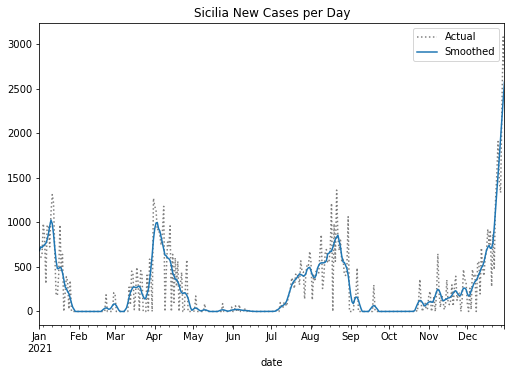

In [13]:
region = 'Sicilia'

def prepare_cases(cases, cutoff=25):
    #cases=cases.shift(-14, freq='D')
    new_cases = cases.diff()
## there is a drop in some databases of number of cumulated infected, therefore we observe a .diff()
## that is negative. So everything that is negative, we set it to 0. to do not break the program
    new_cases[new_cases < 0.] = 0.
    
    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    zeros = smoothed.index[smoothed.eq(0)|smoothed.isnull()]
    if len(zeros) == 0:
        idx_start = 0
    else:
#       last_zero = zeros.max()
#       idx_start = smoothed.index.get_loc(last_zero) + 1
        idx_start = 0
    smoothed = smoothed.fillna(0).iloc[idx_start:]
    #original = new_cases.fillna(0).loc[smoothed.index]
    #smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

#cases = states.xs(region).rename(f"{region} cases")

original, smoothed = prepare_cases(states.xs(region))

original.plot(title=f"{region} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
               figsize=(600/72, 400/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)
ax.get_figure().set_facecolor('w')

#### Function for Calculating the Posteriors

To calculate the posteriors we follow these steps:
1. Calculate $\lambda$ - the expected arrival rate for every day's poisson process
2. Calculate our initial prior because our first day does not have a previous day from which to take the posterior
3. Calculate each day's likelihood distribution over all possible values of $R_t$


In [14]:
def get_posteriors(sr, window=10, min_periods=1):
    cols = sr.index
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    # Note: if you want to have a Uniform prior you can use the following line instead.
    # I chose the gamma distribution because of our prior knowledge of the likely value
    # of R_t.
    
    # prior0 = np.full(len(r_t_range), np.log(1/len(r_t_range)))
    prior0 = np.log(sps.gamma(a=3).pdf(r_t_range) + 1e-14)

    likelihoods = pd.DataFrame(
        # Short-hand way of concatenating the prior and likelihoods
        data = np.c_[prior0, sps.poisson.pmf(sr[1:].values, lam)],
        index = r_t_range,
        columns = sr.index)

    # Perform a rolling sum of log likelihoods. This is the equivalent
    # of multiplying the original distributions. Exponentiate to move
    # out of log.
    posteriors = likelihoods.rolling(window,
                                     axis=1,
                                     min_periods=min_periods).sum()
    posteriors = np.exp(posteriors)

    # Normalize to 1.0
    posteriors = posteriors.div(posteriors.sum(axis=0), axis=1)
    
    return posteriors

posteriors = get_posteriors(smoothed)
posteriors.isnull().any().unique()

array([False])

In [15]:
posteriors

date,2021-01-01,2021-01-02,2021-01-03,2021-01-04,2021-01-05,2021-01-06,2021-01-07,2021-01-08,2021-01-09,2021-01-10,...,2021-12-21,2021-12-22,2021-12-23,2021-12-24,2021-12-25,2021-12-26,2021-12-27,2021-12-28,2021-12-29,2021-12-30
0.00,1.000520e-16,9.993040e-17,9.983221e-17,9.972294e-17,9.961608e-17,9.951089e-17,9.940033e-17,9.929199e-17,9.919018e-17,9.909816e-17,...,0.000828,0.000828,0.000829,0.000829,0.000829,0.00083,0.00083,0.00083,0.00083,0.000831
0.01,4.952825e-07,4.946804e-07,4.941943e-07,4.936534e-07,4.931244e-07,4.926037e-07,4.920564e-07,4.915201e-07,4.910161e-07,4.905606e-07,...,0.000828,0.000828,0.000829,0.000829,0.000829,0.00083,0.00083,0.00083,0.00083,0.000831
0.02,1.961417e-06,1.959033e-06,1.957108e-06,1.954966e-06,1.952871e-06,1.950809e-06,1.948641e-06,1.946518e-06,1.944522e-06,1.942718e-06,...,0.000828,0.000828,0.000829,0.000829,0.000829,0.00083,0.00083,0.00083,0.00083,0.000831
0.03,4.369277e-06,4.363965e-06,4.359678e-06,4.354906e-06,4.350239e-06,4.345646e-06,4.340817e-06,4.336086e-06,4.331640e-06,4.327622e-06,...,0.000828,0.000828,0.000829,0.000829,0.000829,0.00083,0.00083,0.00083,0.00083,0.000831
0.04,7.690315e-06,7.680966e-06,7.673419e-06,7.665020e-06,7.656806e-06,7.648721e-06,7.640223e-06,7.631896e-06,7.624070e-06,7.616998e-06,...,0.000828,0.000828,0.000829,0.000829,0.000829,0.00083,0.00083,0.00083,0.00083,0.000831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11.96,4.576108e-06,4.570545e-06,4.566054e-06,4.561056e-06,4.556169e-06,4.551358e-06,4.546301e-06,4.541346e-06,4.536689e-06,4.532481e-06,...,0.000828,0.000828,0.000829,0.000829,0.000829,0.00083,0.00083,0.00083,0.00083,0.000831
11.97,4.538154e-06,4.532637e-06,4.528184e-06,4.523228e-06,4.518381e-06,4.513609e-06,4.508595e-06,4.503681e-06,4.499063e-06,4.494889e-06,...,0.000828,0.000828,0.000829,0.000829,0.000829,0.00083,0.00083,0.00083,0.00083,0.000831
11.98,4.500509e-06,4.495038e-06,4.490621e-06,4.485706e-06,4.480900e-06,4.476168e-06,4.471195e-06,4.466321e-06,4.461742e-06,4.457603e-06,...,0.000828,0.000828,0.000829,0.000829,0.000829,0.00083,0.00083,0.00083,0.00083,0.000831
11.99,4.463170e-06,4.457744e-06,4.453364e-06,4.448490e-06,4.443723e-06,4.439031e-06,4.434099e-06,4.429266e-06,4.424724e-06,4.420620e-06,...,0.000828,0.000828,0.000829,0.000829,0.000829,0.00083,0.00083,0.00083,0.00083,0.000831


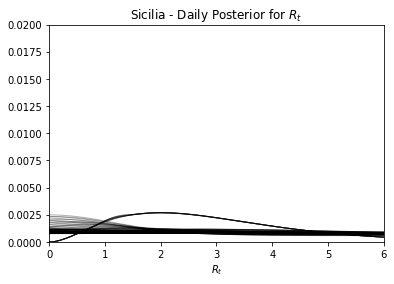

In [17]:
ax = posteriors.plot(title=f'{region} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0,6),
           ylim=(0,0.02))

ax.set_xlabel('$R_t$');

In [18]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.head()

,ML,Low_90,High_90
date,,,
2021-01-01,2.0,0.50,5.54
2021-01-02,2.0,0.46,5.49
2021-01-03,2.0,0.47,5.50
2021-01-04,2.0,0.48,5.51
2021-01-05,2.0,0.49,5.52


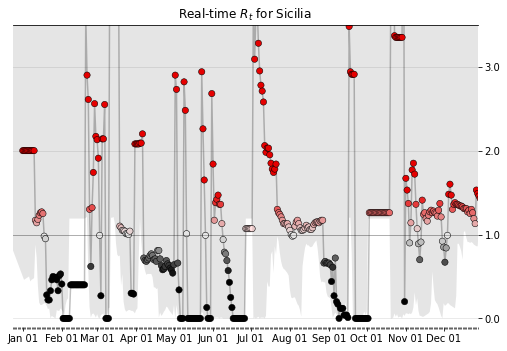

In [19]:
def plot_rt(result, ax, region):
    
    ax.set_title(f"{region}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)

    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                    result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                     result['High_90'].values,
                     bounds_error=False,
                    fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-12-24'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(-0.1,3.5)
    ax.set_xlim(pd.Timestamp('2020-12-24'), result[:-3].index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, region)
ax.set_title(f'Real-time $R_t$ for {region}')
#ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

In [24]:
FILTERED_REGIONS=[]

results = {}

states_to_process = states.loc[~states.index.get_level_values('sub_region_1').isin(FILTERED_REGIONS)]

for state_name, cases in states_to_process.groupby(level='sub_region_1'):
        
    clear_output(wait=True)
    print(f'Processing {state_name}')
    
    cases=cases.droplevel(0)
    new, smoothed = prepare_cases(cases)
    print('\tGetting Posteriors')
    try:
        posteriors = get_posteriors(smoothed)
    except:
        display(cases)
    print('\tGetting HDIs')
    hdis = highest_density_interval(posteriors)
    print('\tGetting most likely values')
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis], axis=1)
    results[state_name] = result
    #.droplevel(0)
    
clear_output(wait=True)
print('Done.')

Done.


In [26]:
today=str(pd.to_datetime('today').date())

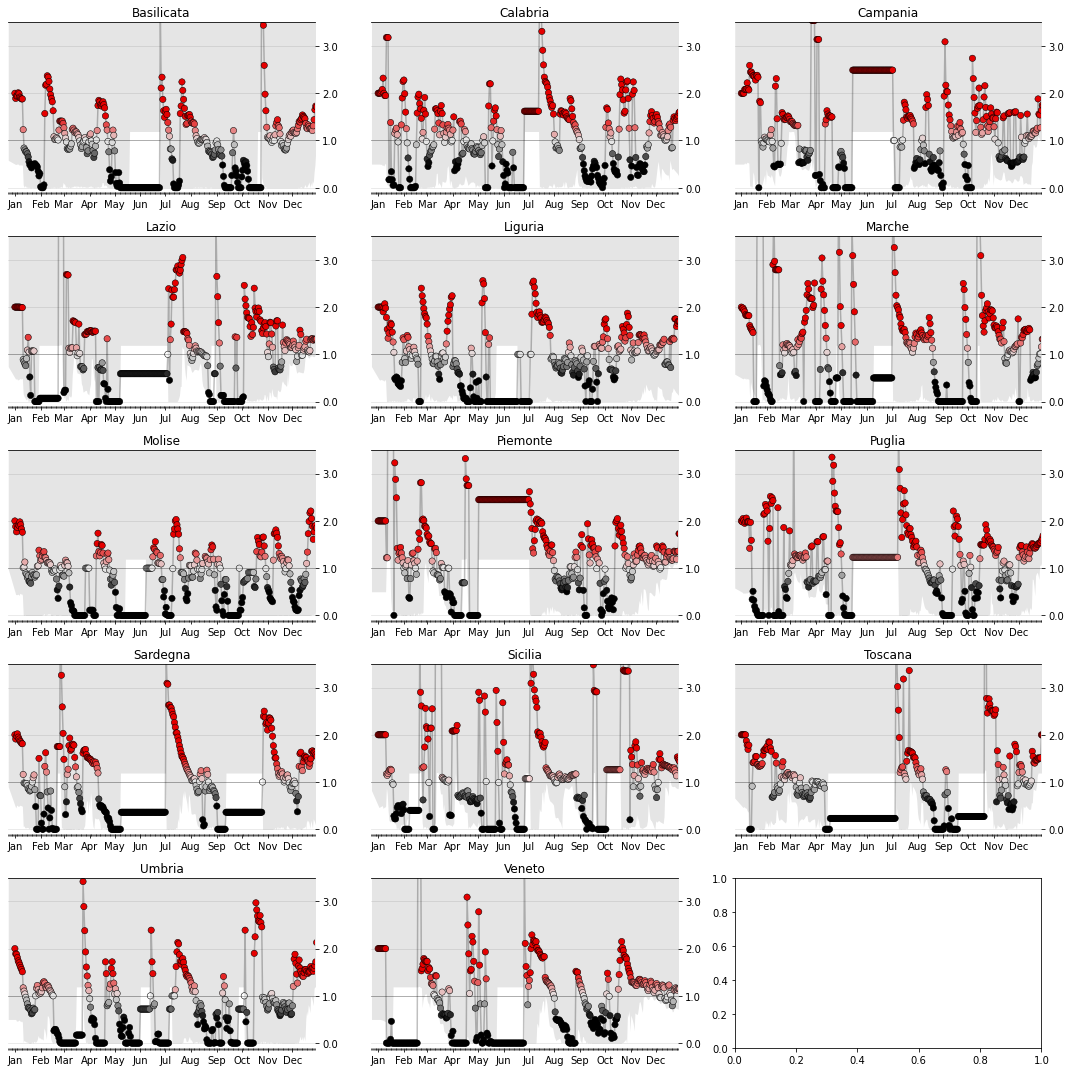

In [28]:
ncols = 3
nrows = int(np.ceil(len(results) / ncols))

import os

os.makedirs("Figures/", exist_ok = True)

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (state_name, result) in enumerate(results.items()):
    plot_rt(result, axes.flat[i], state_name)

fig.tight_layout()
fig.set_facecolor('w')

plt.savefig('R_t_all_region')

In [29]:
overall = None

for state_name, result in results.items():
    r = result.copy()
    r.index = pd.MultiIndex.from_product([[state_name], result.index])
    if overall is None:
        overall = r
    else:
        overall = pd.concat([overall, r])

overall.sort_index(inplace=True)

FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

In [30]:
overall.to_csv('Rt_per_region.csv')
overall

ML  Low_90  High_90
           date                             
Basilicata 2021-01-01  2.00    0.50     5.54
           2021-01-02  1.89    0.49     5.48
           2021-01-03  1.94    0.50     5.45
           2021-01-04  1.95    0.50     5.41
           2021-01-05  2.01    0.50     5.38
...                     ...     ...      ...
Veneto     2021-12-26  1.15    0.73    11.54
           2021-12-27  1.12    0.73    11.54
           2021-12-28  1.15    0.72    11.53
           2021-12-29  1.15    0.73    11.54
           2021-12-30  1.15    0.90    11.71

[5093 rows x 3 columns]

C:\Users\ADMIN\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(<Figure size 1080x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Most Recent $R_t$ by Region'}>)

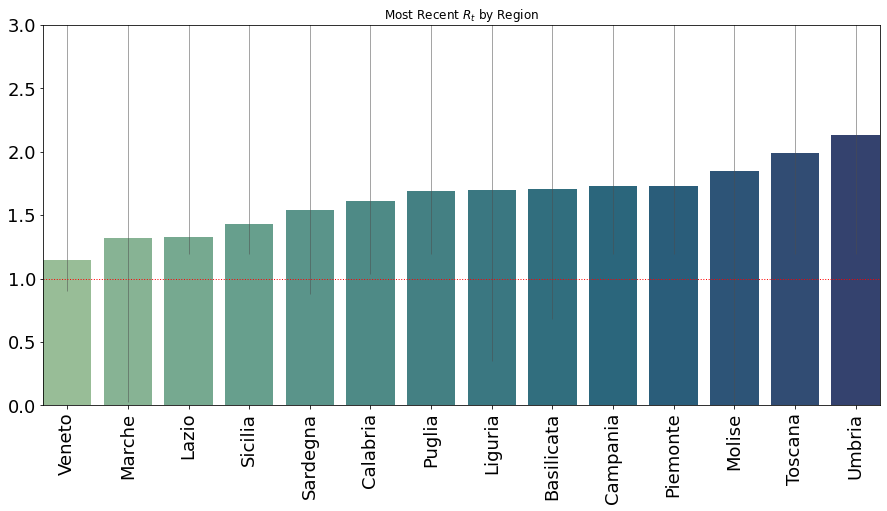

In [36]:
import seaborn as sns
filtered = overall.index.get_level_values(0).isin(FILTERED_REGIONS)
mr = overall.loc[~filtered].groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

mr=mr[mr['ML']>0]

def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by Region', fontsize=14):
    #if not figsize:
    #    figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=(15,7))

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = sns.barplot(mr.index,
                  mr['ML'],
                  #width=.825,
                  #color=mr.ML.values,
                  ecolor=ERROR_BAR_COLOR,
                  palette='crest',
    
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    #for bar, state_name in zip(bars, mr.index):
    #    if state_name in no_lockdown:
    #        bar.set_color(NONE_COLOR)
    #    if state_name in partial_lockdown:
    #        bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series()
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,3)
    plt.yticks(fontsize=18)
    plt.ylabel("")
    ax.axhline(1.0, linestyle=':', color='red', lw=1)
    ax.set_xticklabels(labels, fontsize=18)


    #leg = ax.legend(handles=[
    #                    Patch(label='Full', color=FULL_COLOR),
    #                    Patch(label='Partial', color=PARTIAL_COLOR),
    #                    Patch(label='None', color=NONE_COLOR)
    #                ],
    #                title='Lockdown',
    #                ncol=3,
    #                loc='upper left',
    #                columnspacing=.75,
    #                handletextpad=.5,
    #                handlelength=1)

    #leg._legend_box.align = "left"
    #fig.set_facecolor('w')
    plt.savefig('R_t_value')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr)